## SARIMA on BYOML
In this notebook we will demonstrate how you can use a statistical  model like SARIMA, upload it to byoml and afterwards perform a (forecasting) prediction with the deployed model.

This uses the `custom` framework, supported by BYOML since version `1.4.0`, to use the [statsmodels](https://www.statsmodels.org) implementation of [SARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarima#statsmodels.tsa.statespace.sarimax.SARIMAX).

We use WPI data from [stata](https://www.stata-press.com/data/). See also Example 5 in [this](https://www.stata.com/manuals/tsforecastestimates.pdf) stata manual.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import httpx
import statsmodels.api as sm

from io import BytesIO

In [6]:
wpi1 = httpx.get('https://www.stata-press.com/data/r17/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
# set quarter index frequency: not necessary, but suppresses warnings
data.index.freq='QS'
data = data[['wpi']]

<AxesSubplot:xlabel='t'>

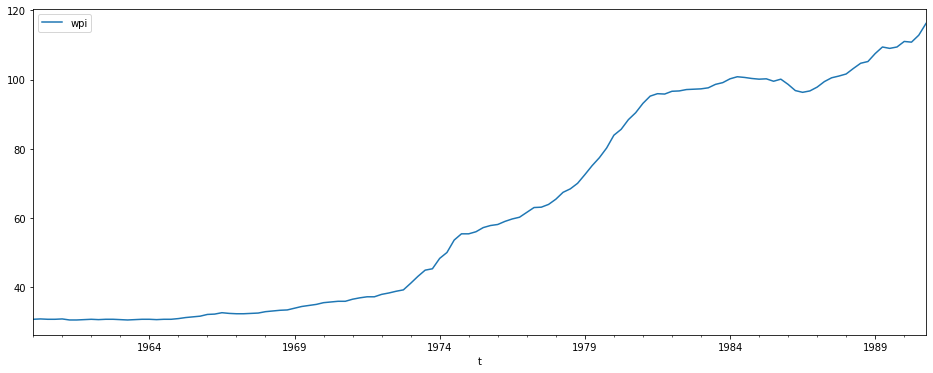

In [7]:
data.plot(figsize = (16, 6))

#### train and test data

In [8]:
train_size = int(len(data.index) * 0.9)
df_train, df_test = data.iloc[:train_size], data.iloc[train_size:]
print(df_train.head())
print(df_test.head())

                  wpi
t                    
1960-01-01  30.700001
1960-04-01  30.799999
1960-07-01  30.700001
1960-10-01  30.700001
1961-01-01  30.799999
                   wpi
t                     
1987-10-01  101.000000
1988-01-01  101.599998
1988-04-01  103.199997
1988-07-01  104.699997
1988-10-01  105.199997


#### model fitting

This sarima model uses hyperparameters that set first order (`1,1,1`) modeling on the autoregression (AR), differencing (I), and moving average (MA) parts, both for the 1-step prediction (`order`) as for the seasonal (S) component (`seasonal_order`). 

We set a seasonality of `4` for a yearly season on quarterly data.

We do not use the _exogenous_ (X) component supported by this model.

First we will create a local model, later we can compare results of the served model to this local model.

In [9]:
model = sm.tsa.SARIMAX(
    df_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4),
)
fitted_model = model.fit(maxiter=250, disp=10)
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09970D+00    |proj g|=  2.19501D-01

At iterate   10    f=  9.82291D-01    |proj g|=  2.09852D-02

At iterate   20    f=  9.79926D-01    |proj g|=  2.43336D-03


 This problem is unconstrained.



At iterate   30    f=  9.79780D-01    |proj g|=  2.32556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     62      1     0     0   1.155D-03   9.798D-01
  F =  0.97977439205787609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               wpi   No. Observations:                  111
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -108.755
Date:                           Thu, 09 Jun 2022   AIC                            227.510
Time:                                   15:30:10   BIC                            240.827
Sample:                               01-01-1960   HQIC                           232.907
                                    - 07-01-1987                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8557      0.071     11.969      0.000       0.716       0.996
ma.L1         -0.3205      0.127     -2.527      0.012      -0.569      -0.072
ar.S.L4        0.1429      0.127      1.129      0.259      -0.105       0.391
ma.S.L4       -0.9989      5.299     -0.188      0.850     -11.386       9.388
sigma2         0.4090      2.162      0.189      0.850      -3.828       4.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.29
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              21.40   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

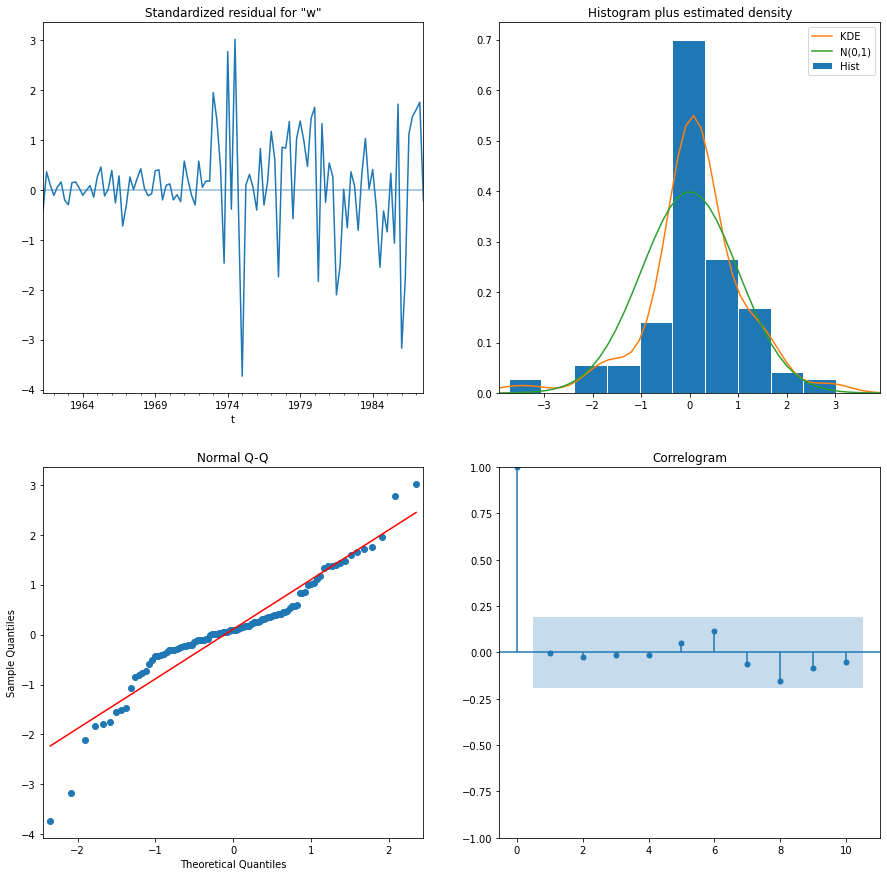

In [7]:
diag_plot = fitted_model.plot_diagnostics(figsize=(15, 15))


#### one-step forecast (in-band)
The following cell performs a one-step ahead forecast of the 30 latest data points.

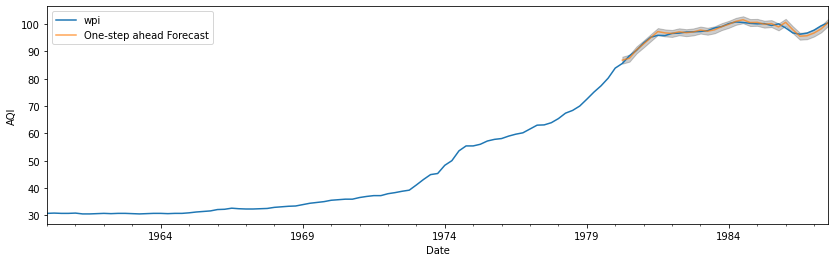

In [10]:
prediction = fitted_model.get_prediction(start=-30)
pred_ci = prediction.conf_int(alpha=0.05)
pred_mean = prediction.predicted_mean
ax = df_train.plot(label='observed')
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='k', alpha=.2
)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

#### forecast (future prediction)

The `forecast` method of the fitted model will give you predictions in the future.

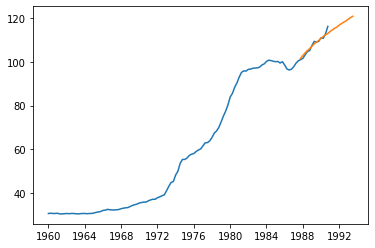

In [11]:
forecast_window = 24
forecast = fitted_model.forecast(steps=forecast_window)
plt.plot(data.index, data.wpi)
plt.plot(forecast.index, forecast.values)

The `get_forecast` method also gives confidence intervals.

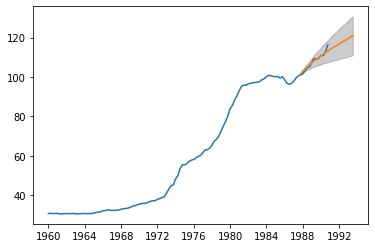

In [12]:
forecast = fitted_model.get_forecast(steps=forecast_window)
forecast_mean = forecast.predicted_mean
# using a 50% confidence interval:
forecast_ci = forecast.conf_int(alpha=0.5)
plt.plot(data.index, data.wpi)
plt.plot(forecast_mean.index, forecast_mean.values)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], 
    color='k', alpha=.2
)
plt.show()

Let's create a custom BYOML model wrapper that we can fit and deploy to BYOML.
We set up the waylay client. 

In [13]:
from waylay import WaylayClient, RestResponseError, __version__
waylay = WaylayClient.from_profile()

# diagnostis
display(__version__)
display(waylay.byoml.root_url)
display(waylay.byoml.about.health())


'v0.4.0'

'https://byoml-staging.waylay.io'

'OK: byoml-1.4.2+3.gbe99dc7'

## data conversion
Our model uses use pandas timeseries, but when deplloyed, the byoml runtime hands over numpy arrays to the `predict` method.

The following functions convert from and to numpy arrays of shape ( nr_of_observations, 2). The inner records are a (timestamp, value) with timestamps encoded as epoch milliseconds, e.g. as produced by the `executeQuery`(http://docs-io.waylay.io/#/sensors/executeQuery) plug with the `removeTimestamps=false` option.

A typical request that would be sent to the deployed byoml function would be (`Content-Type: application/json`)
```http
POST /models/sarima-model/predict 
{
  "instances" : [
     [-315619200000.0, 30.700000762939453],
     [-307756800000.0, 30.799999237060547],
     [-299894400000.0, 30.700000762939453],
     ...
  ]
}
```


In [14]:
def convert_to_pandas(data):
    # to make the model behave the same when fitting and when deployed
    if isinstance(data, list):
        data = np.array(data)
    if isinstance(data, np.ndarray):
        (instance_count, row_count) = data.shape
        if row_count == 2:
            timestamps, values = data.transpose()                
        elif instance_count == 2:
            timestamps, values = data
        else:
            raise ValueError('This model requires a timestamp and value row as input')

        if len(timestamps) and isinstance(timestamps[0], np.number):
            # millisecond epoch is standard for waylay
            data = pd.DataFrame(values, index=pd.to_datetime(timestamps, unit='ms'))
        else:
            data = pd.DataFrame(values, index=pd.to_datetime(timestamps))
        data.index.freq='QS'

    if not isinstance(data, pd.DataFrame):
        raise ValueError('This model requires an input that can be converted to a dataframe.')
        
    return data

def convert_to_numpy(series_or_df):
    # convert dataframe to an array of (timestamp_millis, value) tuples
    timestamps = series_or_df.index.map(lambda _ : _.timestamp() * 1000).values
    if isinstance(series_or_df, pd.DataFrame):
        df = series_or_df
        series = [ df[c].values for c in df.columns ]
        return np.array([timestamps, *series]).transpose()
    else:
        series = series_or_df.values
        return np.array([timestamps, series]).transpose()


Check these functions with a roundtrip on the first lines of our data set:

In [15]:
json_data = convert_to_numpy(data.head()).tolist()
display(json_data)
pandas_data = convert_to_pandas(json_data)
display(pandas_data)

[[-315619200000.0, 30.700000762939453],
 [-307756800000.0, 30.799999237060547],
 [-299894400000.0, 30.700000762939453],
 [-291945600000.0, 30.700000762939453],
 [-283996800000.0, 30.799999237060547]]

,0
1960-01-01,30.700001
1960-04-01,30.799999
1960-07-01,30.700001
1960-10-01,30.700001
1961-01-01,30.799999


## Byoml Model wrapper

We now create a helper class around the SARIMA model and test the local predict method.
* it has a `fit` method to train the model before we upload it. The fitted state is stored in an object attribute,
  so that it will be available when running the model on the BYOML runtime.
* it has a `predict` method that will be used in the deployed model to restore the fitted model on an array of historical data, and perform a prediction after this input.
* the `window` attribute defines the forecasting window used when calling `predict`.
* it uses the hooks `map_input` and `map_output` to convert input and output from and the plain json-serializable data structures that the BYOML runtime receives and sends. The byoml runtime will recognize these hooks by their names.

In [16]:
class SARIMAXForecaster:
    def __init__(self, window=24):
        self.window = window
        self.fitted_params = None

    def map_input(self, request):
        """Convert the json-data request payload to the input for `predict`."""
        return convert_to_pandas(request['instances'])
    
    def map_output(self, request, result):
        """Convert the output of `predict` to a json-data response payload."""
        return { 'predictions': convert_to_numpy(result).tolist() }

    def create_model(self, data):
        return sm.tsa.SARIMAX(
            data,
            seasonal_order=(1, 1, 1, 4),
            order=(1, 0, 0),
            trend=[1, 0, 0],
            enforce_stationarity=False
        )
    
    def fit(self, data, **fit_args):
        fitted_model = self.create_model(data).fit(**fit_args)
        self.fitted_params = fitted_model.params
        return fitted_model
    
    def get_fitted_model(self, data):
        model = self.create_model(data)
        if self.fitted_params is None:
            raise ValueError('Model has not been fitted')
        return model.smooth(self.fitted_params)
        
    def predict(self, data):
        fitted_model = self.get_fitted_model(data)
        return fitted_model.forecast(steps=self.window)


In [17]:
# fit and test the wrapped model
upload_model = SARIMAXForecaster()
upload_model.fit(df_train, disp=0)
preds_df = upload_model.predict(df_train)
preds_df.head()

1987-10-01    101.215103
1988-01-01    102.439452
1988-04-01    103.809061
1988-07-01    104.943745
1988-10-01    105.799706
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [18]:
# test including the data conversion:
## this would be the data sent to byoml
json_data_req = { 'instances': convert_to_numpy(df_train).tolist() }

## these are the steps the byoml service will invoke on the model wrapper
mapped_input = upload_model.map_input(json_data_req)
preds_df = upload_model.predict(mapped_input)
mapped_output = upload_model.map_output(json_data_req, preds_df)

## this would be the response data sent back
display(mapped_output)

{'predictions': [[560044800000.0, 101.21510338443233],
  [567993600000.0, 102.43945209512108],
  [575856000000.0, 103.80906145925209],
  [583718400000.0, 104.9437448154566],
  [591667200000.0, 105.79970630794074],
  [599616000000.0, 107.07738401412374],
  [607392000000.0, 108.33745314588052],
  [615254400000.0, 109.48450326608331],
  [623203200000.0, 110.40172540508073],
  [631152000000.0, 111.70055448396292],
  [638928000000.0, 112.90704612841427],
  [646790400000.0, 114.05663177268353],
  [654739200000.0, 114.99895224382364],
  [662688000000.0, 116.30454546980766],
  [670464000000.0, 117.48355759999622],
  [678326400000.0, 118.63153466196509],
  [686275200000.0, 119.58269953170452],
  [694224000000.0, 120.88879666885572],
  [702086400000.0, 122.05265976160277],
  [709948800000.0, 123.197452961546],
  [717897600000.0, 124.15031268128956],
  [725846400000.0, 125.45434605591541],
  [733622400000.0, 126.60902465915252],
  [741484800000.0, 127.75020002891434]]}

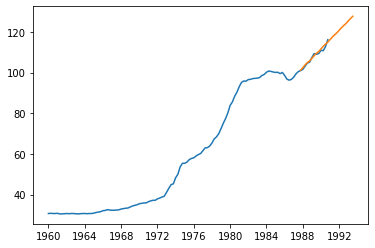

In [19]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(preds_df.index, preds_df.values)

Define the model name for this notebook, delete any model with that name that would already exist. 

In [20]:
MODEL_NAME = 'sarima-model'

try:
    resp = waylay.byoml.model.remove(MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

{'message': 'Model sarima-model: all versions deleted',
 'name': 'sarima-model',
 'versions': []}

To deploy our model on BYOML, we will need to save the model using the `dill` library and upload it together with a `requirements` argument that includes the `statsmodels` library.

In [21]:
# check wether your deployment supports the `custom` framework
waylay.byoml.framework.get('custom')

{'default_runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'framework': 'custom',
 'versions': ['1.0']}

In [22]:
waylay.byoml.model.upload(
    MODEL_NAME,
    upload_model,
    framework='custom',
    description='SARIMA model example',
    requirements='statsmodels==0.13',
)

ByomlActionError: ByomlActionError(502: 'operation=server_error'; POST 'https://byoml-staging.waylay.io/models')

Listing the models won't affect the deployment status of the model

In [26]:
waylay.byoml.model.list(params={"name":MODEL_NAME})

[{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'createdOn': '2022-06-09T13:32:14.963000+00:00',
  'description': 'SARIMA model example',
  'framework': 'custom',
  'framework_version': '1.0',
  'metadata': {'description': 'SARIMA model example'},
  'name': 'sarima-model',
  'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'updatedOn': '2022-06-09T13:32:15.001000+00:00',
  'version': '1'},
 {'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'createdOn': '2021-10-15T14:53:50.628000+00:00',
  'description': 'SARIMA model example with confidence intervals',
  'framework': 'custom',
  'framework_version': '1.0',
  'metadata': {'description': 'SARIMA model example with confidence intervals'},
  'name': 'sarima-model-ci',
  'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'updatedOn': '2021-10-15T14:53:52.767000+00:00',
  'version': '1'},
 {'createdOn': '2021-07-02T11:15:51.976000+00:00',
  'description': 'SARIMA model example',
  'framework'

Getting the model, will check that the model is ready to serve ...

In [28]:
waylay.byoml.model.get(MODEL_NAME, params={"debug": True})

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2022-06-09T13:32:14.963000+00:00',
 'description': 'SARIMA model example',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example'},
 'name': 'sarima-model',
 'ready': False,
 'runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-da8781cc0d4dc5602d7c6c5a0b0b157e3592b04e.openfaas-fn-6ccc8843-d78d-49e8-84c4-3734a4af9929',
 'status': 'running',
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2022-06-09T13:32:15.001000+00:00',
 'version': '1'}

When requesting predictions, the python SDK will retry until the model is ready to serve (see [retry handling](http://docs-io.waylay.io/#/api/sdk/python?id=retry-handling))

In [30]:
predictions = waylay.byoml.model.predict(MODEL_NAME, convert_to_numpy(df_train))
predictions_df = convert_to_pandas(predictions)
predictions_df.head()

,0
1987-10-01,101.215103
1988-01-01,102.439452
1988-04-01,103.809061
1988-07-01,104.943745
1988-10-01,105.799706


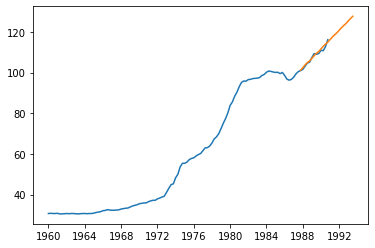

In [31]:
plt.plot(
    data.index,
    data.wpi
)
plt.plot(
    predictions_df.index,
    predictions_df.values
)

In [32]:
# remove the deployed model
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model sarima-model: all versions deleted',
 'name': 'sarima-model',
 'versions': ['0.0.1']}

### TODO
#### urgent
* upload fails with a `ByomlActionError(502: 'operation=server_error'; POST 'https://byoml-staging.waylay.io/models')` (bad gateway) ... streaming issue to byoml/plug-repository? The model is created.
* after deletion and update, sometimes get a `LocalProtocolError: Too little data for declared Content-Length
` (and the model is not created). Probably an issue in waylay-py.
* after creating a model plug, the openfaas function will not be available for a while, issuing a NOT FOUND, this is a recent change on plug-registry/openfaas. We can work around in in byoml: convert 403 errors to not ready errors so that the retry mechanisms in python SDK work again.


#### Later
> * integrate `convert_to_pandas` and `convert_to_numpy` into the python SDK and/or model wrapper at byoml-images?

##  parameterization: confidence intervals


Let's adapt the model to support confidence intervals instead of mean predictions. This also shows how you can pass custom parameters to you model inference.

In [33]:
class SARIMAXConfidenceForecaster:
    def __init__(self, window=24, default_alpha=0.05):
        self.window = window
        self.fitted_params = None
        self.default_alpha = default_alpha

    def map_input(self, request):
        """Convert the json-data request payload to the input for `predict`."""
        # allow the user to specify an alternate alpha for the confidence intervals
        alpha = request.get('alpha', self.default_alpha)
        return (
            convert_to_pandas(request['instances']),
            alpha
        )

    def map_output(self, request, result):
        """Convert the output of `predict` to a json-data response payload."""
        return { 'predictions': convert_to_numpy(result).tolist() }

    def create_model(self, data):
        return sm.tsa.SARIMAX(
            data,
            seasonal_order=(1, 1, 1, 4),
            order=(1, 0, 0),
            trend=[1, 0, 0],
            enforce_stationarity=False
        )
    
    def fit(self, data, **fit_args):
        fitted_model = self.create_model(data).fit(**fit_args)
        self.fitted_params = fitted_model.params
        return fitted_model
    
    def get_fitted_model(self, data):
        model = self.create_model(data)
        if self.fitted_params is None:
            raise ValueError('Model has not been fitted')
        return model.smooth(self.fitted_params)
        
    def predict(self, data_and_alpha):
        data, alpha = data_and_alpha
        fitted_model = self.get_fitted_model(data)
        forecast = fitted_model.get_forecast(steps=self.window)
        return forecast.conf_int(alpha)


In [34]:
CI_MODEL_NAME = 'sarima-model-ci'
try:
    resp = waylay.byoml.model.remove(CI_MODEL_NAME)
    display(resp)
except RestResponseError as e:
    display(f'Ignored: {e}')

{'message': 'Model sarima-model-ci: all versions deleted',
 'name': 'sarima-model-ci',
 'versions': ['0.0.1']}

In [35]:
upload_model_ci = SARIMAXConfidenceForecaster()
upload_model_ci.fit(df_train, disp=0)

# test locally
upload_model_ci.predict(( df_train, 0.5)).head()

,lower wpi,upper wpi
1987-10-01,99.587552,102.842655
1988-01-01,100.173203,104.705701
1988-04-01,101.076452,106.541671
1988-07-01,101.836353,108.051136
1988-10-01,101.967948,109.631465


In [36]:
# upload model
waylay.byoml.model.upload(
    CI_MODEL_NAME,
    upload_model_ci,
    framework='custom',
    description='SARIMA model example with confidence intervals',
    requirements='lib/sarima_byoml_wrapper',
    lib='./custom_lib'
)

ByomlActionError: ByomlActionError(502: 'operation=server_error'; POST 'https://byoml-staging.waylay.io/models')

In [37]:
waylay.byoml.model.get(CI_MODEL_NAME, params={'debug': True})

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2022-06-09T13:36:50.609000+00:00',
 'description': 'SARIMA model example with confidence intervals',
 'framework': 'custom',
 'framework_version': '1.0',
 'metadata': {'description': 'SARIMA model example with confidence intervals'},
 'name': 'sarima-model-ci',
 'ready': False,
 'runtime': {'framework': 'custom',
  'framework_version': '1.0',
  'name': 'byoml-custom-1.0',
  'python_version': '3.7'},
 'semantic_version': '0.0.1',
 'serving_name': 'kf-a9ff10137ac355b2a68620c5a8ae3ea5b59570da.openfaas-fn-6ccc8843-d78d-49e8-84c4-3734a4af9929',
 'status': 'running',
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2022-06-09T13:36:50.638000+00:00',
 'version': '1'}

In [38]:
predictions = waylay.byoml.model.predict(CI_MODEL_NAME, convert_to_numpy(df_train))
predictions_df = convert_to_pandas(predictions)
predictions_df.head()

ValueError: This model requires a timestamp and value row as input

In [ ]:
# use the `body` argument to add additional parameters in a prediction request
predictions = waylay.byoml.model.predict(CI_MODEL_NAME, convert_to_numpy(df_train), body={'alpha': 0,5})
predictions_df = convert_to_pandas(predictions)
predictions_df.head()

In [ ]:
import dill
from pathlib import Path
model_dump_file =  Path.home() / 'tmp' /  'dill_test.dill'
with open(model_dump_file, 'wb') as f:
    dill.settings['recurse'] = False
    dill.dump(upload_model_ci, f)

In [ ]:
! ls -l ~/tmp/dill*

In [50]:
with open(model_dump_file, "rb") as f:
    upload_model_ci_reloaded = dill.load(f)
    
upload_model_ci_reloaded.fitted_params

intercept    0.074144
ar.L1        0.968947
ar.S.L4      0.459466
ma.S.L4     -0.999530
sigma2       0.664334
dtype: float64

In [30]:
Path.home()

PosixPath('/Users/thomas')

In [31]:
upload_model.fitted_params

intercept    0.074144
ar.L1        0.968947
ar.S.L4      0.459466
ma.S.L4     -0.999530
sigma2       0.664334
dtype: float64

In [51]:
session_dump_file =  Path.home() / 'tmp' /  'dill_test.session.dill'
with open(session_dump_file, 'wb') as f:
    dill.dump_session(session_dump_file, f)

In [1]:
import sarima_byoml_wrapper as sw

In [12]:
upload_model_ci = sw.SARIMAXConfidenceForecaster()
upload_model_ci.fit(df_train, disp=0)

# test locally
upload_model_ci.predict(( df_train, 0.5)).head()

,lower wpi,upper wpi
1987-10-01,99.587552,102.842655
1988-01-01,100.173203,104.705701
1988-04-01,101.076452,106.541671
1988-07-01,101.836353,108.051136
1988-10-01,101.967948,109.631465
